Task: train on round 0 + 1, test on round 2  
Model: the same as the model we used to design round 2  
Questions to answer: 
- does the design conforms to what we expected?
    - are the sequences with top predicted mean have high TIR scores as well? Rank matters. 
    - For the sequences with high uncertainty, how does the exploration go? Can we open up/rollout new areas?
    - what part of the results turn out to be surprising and why? Can we learn something to design a better round in the next step?



In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

known_df = pd.read_csv(Path)
known_df.head()


,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# read train and test df from known data

train_df = known_df[known_df['Round']!=2]
test_df = known_df[known_df['Round'] == 2]

In [4]:
# copy from the pipeline for recommending round 2 seq

rec_size = 90
l = 6
s = 1
beta = 1
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

In [5]:
# train on train_df and test on test_df

top_n = Top_n_ucb(train_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag,
                 df_design= test_df)

In [6]:
top_n.prediction()

# write prediction to df_design
# AVERAGE: true TIR; pred mean/std: predictions
df_design = top_n.df_design

X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


### Show prediction vs true labels for round 2

The following plot shows the prediction in terms of a classification view. 
We identify "high TIR" RBS as the one with label higher than 1.
We use the color to show the predicted std. 
Given that we only have a small amount of data and we are exploring the design space, we are unlikely to be able to predict the label in precise.
So instead of a "regression" type of evaluation, we are more care about the following:
- whether we are able to exploit the design space? We expect the high TIR sequences are predicted to be high. 
- whether we are able to learn the label in the area we have high confidence? We expect the RBS with low predicted std would have predicted mean close to true TIR. 

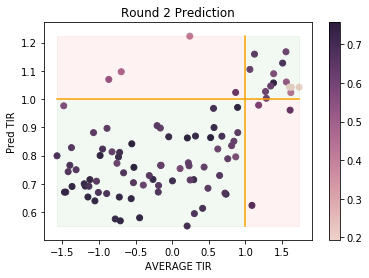

In [35]:
import seaborn as sns

threshold = 1.0
xlims = [df_design['AVERAGE'].min(), df_design['AVERAGE'].max()]
ylims = [df_design['pred mean'].min(), df_design['pred mean'].max()]

cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(df_design['AVERAGE'], df_design['pred mean'], c = df_design['pred std'], cmap = cmap)
plt.fill_between([xlims[0], threshold], y1 = [threshold], y2= [ylims[-1]], color = 'r', alpha = 0.05)
plt.fill_between([threshold, xlims[1]], y1 = [ylims[0]], y2= [threshold], color = 'r', alpha = 0.05)
plt.fill_between([xlims[0], threshold], y1 = [ylims[0]], y2= [threshold], color = 'g', alpha = 0.05)
plt.fill_between([threshold, xlims[-1]], y1 = [threshold], y2= [ylims[1]], color = 'g', alpha = 0.05)
plt.colorbar()
plt.xlabel('AVERAGE TIR')
plt.ylabel('Pred TIR')
plt.title('Round 2 Prediction')
plt.plot(xlims, [threshold, threshold], color = 'orange')
plt.plot([threshold, threshold],ylims, color = 'orange')

The high and low TIR are classified correctly for most of the points (refer the red region for wrong classifcation).
Several observations:
- the points with pred std ~0.2 is the reference seq. It is predicted to be lower than the true label. 
- the predicted std seems to be very similar, most of them are 0.5-0.7.
- The three points in left upper region have low predicted std, but the prediction means are quite different from the true ones. 
Two very interesting examples there are:  

|RBS6  |AVERAGE|pred mean|pred std|
|------|-------|---------|--------|
|GGGGAG|0.24   |1.22     |0.41    |
|GGGGGG|1.62   |1.02     |0.43    |

clearly our predictor thinks GGGGAG and GGGGGG are similar, but the true label are quite different.
 

In [40]:
df_design.sort_values(['pred std'])[['RBS6', 'AVERAGE','pred mean', 'pred std']]

,RBS6,AVERAGE,pred mean,pred std
357,AGGAGA,1.628994,1.042282,0.193745
356,AGGAGA,1.736237,1.042282,0.193745
355,AGGAGA,1.602961,1.042282,0.193745
306,GGGGAG,0.240990,1.222843,0.415742
351,GGGGGG,1.621905,1.022900,0.434026
...,...,...,...,...
300,GACGCT,-0.156801,0.765504,0.748196
271,CATGCT,0.525377,0.863558,0.753841
281,TTGGCT,-0.552059,0.841683,0.754074
274,CACGCT,0.207623,0.862457,0.755040


Try to answer the questions asked at the beginning of this notebook

- are the sequences with top predicted mean have high TIR scores as well?  
*answer:* for the most of sequences, the classification bewteen high and low TIR are in high accuracy.
- For the sequences with high uncertainty, how does the exploration go? Can we open up/rollout new areas?  
*answer:* it hard to say from the above plot, worth combining observed with the tsne plot.
- what part of the results turn out to be surprising and why? Can we learn something to design a better round in the next step?  
*answer:* There are a few sequences with low predicted std but a very low prediction score (i.e. large difference between pred mean and AVERAGE).

#### check the wds distance between GGGGAG and GGGGGG


In [41]:

with open(config.SAVED_IDX_SEQ_PATH, 'rb') as handle:
    idx_seq = pickle.load(handle)

idx_seq_dict = idx_seq['idx_seq_dict']
# idx_seq_dict

In [44]:
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'
idx1 = idx_seq_dict[pre_design + 'GGGGGG' + pos_design]
idx2 = idx_seq_dict[pre_design + 'GGGGAG' + pos_design]

In [42]:
from codes.kernels_for_GPK import *

wds_kernel = WD_Shift_Kernel(l = 6, s=1)

wd_shift_distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...


In [50]:
print('min distance: ', wd_shift_distance.min(), ' max distance: ', wd_shift_distance.max())
print('wds distance between GGGGGG and GGGGAG is', wd_shift_distance[idx1, idx2])

min distance:  0.0  max distance:  1.5438398706156513
wds distance between GGGGGG and GGGGAG is 0.8560361621129924
